### Audio Classification Data Inspector, Feature Extraction Document
In this document we will read in our data set:
* read in all our audio data, train and test
* inspect the diversity of the audio data
* Then perform feature extraction and cache as a NPY file for MFCC and Mel-Spectrogram.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import helper
import os
import math 

# reproducibility
np.random.seed(42)

### Dataset Read In
In this section we will read in our data set structure which is located in our home holder

```
root:
    kaggle_2018_dataset:
        train:
            wav files for training only, contains catalog.csv
        test:
            wav files for testing our model, contains catalog.csv
        data:
            npy files, feature extraction MFCC and MEL-SPEC
        models:
            trained models
```

In [2]:
# get the data set root directory path
dataset_root_dir = os.path.join("/home/charlesedwards/Documents", 'kaggle_2018_dataset')

# get the train and test data directories
train_dir = os.path.join(dataset_root_dir, 'train')
test_dir = os.path.join(dataset_root_dir, 'test')

# get the catalog.csv for train and test directories
train_catalog_csv = os.path.join(train_dir, 'catalog.csv')
test_catalog_csv = os.path.join(test_dir, 'catalog.csv')

# read the catalog.csv files
train_metadata = pd.read_csv(train_catalog_csv)
test_metadata = pd.read_csv(test_catalog_csv)

# drop unwanted columns 
train_metadata.drop(['license','freesound_id'], axis=1, inplace=True)
test_metadata.drop(['license','freesound_id'], axis=1, inplace=True)

# display the first 5 rows of both metadatas
helper.display_side_by_side([train_metadata.head(),test_metadata.head()], ['train_metadata', 'test_metadata'])

In [3]:
print(len(train_metadata.index))
# merge train_metadata and test_metadata
metadata = pd.concat([train_metadata, test_metadata])
print(len(metadata.index))
metadata.head()

9473
11073


fname         label  manually_verified usage
0  00044347.wav        Hi-hat                0.0   NaN
1  001ca53d.wav     Saxophone                1.0   NaN
2  002d256b.wav       Trumpet                0.0   NaN
3  0033e230.wav  Glockenspiel                1.0   NaN
4  00353774.wav         Cello                1.0   NaN

### Visualize Label Distribution 
In this section of the notebook we will display the label distribution i.e number of audio files per class

Minimum samples per category =  120
Maximum samples per category =  410


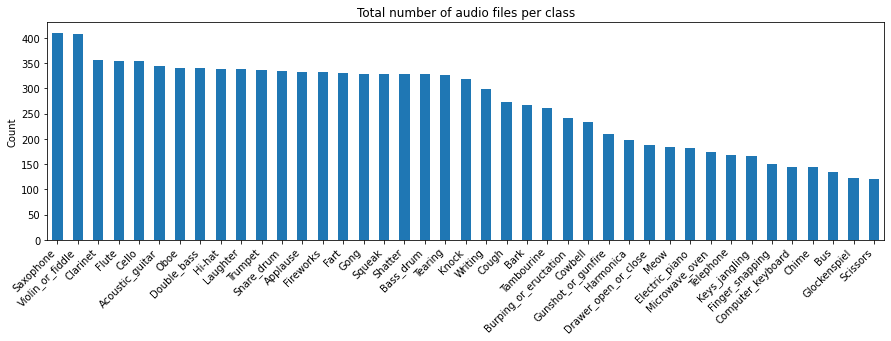

In [4]:
# # visualize the label count distribution
# plt.figure(figsize=(15,4))
# chart = train_metadata['label'].value_counts().plot(kind='bar',)
# chart.set_xticklabels(labels=chart.get_xticklabels(), rotation=45, horizontalalignment='right')
# chart.set_title("Total number of audio files per class")
# chart.set_ylabel('Count')

# print('Minimum samples per category = ', min(train_metadata['label'].value_counts()))
# print('Maximum samples per category = ', max(train_metadata['label'].value_counts()))

# visualize the label count distribution
plt.figure(figsize=(15,4))
chart = metadata['label'].value_counts().plot(kind='bar',)
chart.set_xticklabels(labels=chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_title("Total number of audio files per class")
chart.set_ylabel('Count')

print('Minimum samples per category = ', min(metadata['label'].value_counts()))
print('Maximum samples per category = ', max(metadata['label'].value_counts()))

### Visualize Verified Label Distribution 
In this section of the notebook we will display how many labels are verified vs not

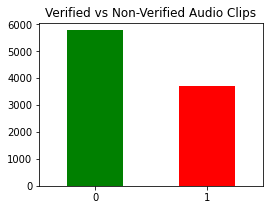

In [5]:
plt.figure(figsize=(4,3))

# plot the number of manually_verified vs non manually_verified audio clips
verified_count = train_metadata['manually_verified'].value_counts()
verified_count.plot(kind='bar', color=['green', 'red'], rot=0, title='Verified vs Non-Verified Audio Clips')


### Read Audio To Memory
This process will take a lot of ram and may vary on dataset size. Atm a 5GB dataset uses roughly 12GB of ram

In [13]:
# Windowing
n_fft=512#1024
hop_length=160#512

DELTA_TIME = 1

def load_data_set(data_dir="TEST AND TRAIN MERGED",metadata_pd=None, sample_rate=22050): #max_duration=2.0):

    processed_data = []
    sample_rates = []
    durations = []

    print(f"Processing audio from: {data_dir} ... with {len(metadata_pd)} files\nn_fft: {n_fft}\nhop_length: {hop_length}")

    length = len(metadata_pd)
    counter = 0

    # using librosa for every fname in our data_frame generate a mel spectrogram and save it to a numpy array
    for x, row in enumerate(metadata_pd.iloc):
        
        target_file = ""
        # detect if row["usage"] is NaN
        #print(str(row["usage"]).lower())
        if str(row["usage"]).lower() == "nan":
            # if nan its a test train
            target_file = os.path.join( train_dir, row['fname'] )
        else:
            target_file = os.path.join( test_dir, row['fname'] )

        # load the audio file
        #y, sr = librosa.load( target_file, sr=sample_rate, duration=max_duration, mono=True )

        sr, y = helper.downsample_mono(target_file, sample_rate)

        delta_sample = int(DELTA_TIME*sample_rate)

        # cleaned audio is less than a single sample
        #wav pad with zeros to delta_sample size
        if y.shape[0] < delta_sample:
            sample = np.zeros(shape=(delta_sample,), dtype=np.int16)
            sample[:y.shape[0]] = y
            #save_sample(sample, rate, target_dir, fn, 0)
        # step through audio and save every delta_sample
        # discard the ending audio if it is too short
        else:
            trunc = y.shape[0] % delta_sample
            for cnt, i in enumerate(np.arange(0, y.shape[0]-trunc, delta_sample)):
                start = int(i)
                stop = int(i + delta_sample)
                sample = y[start:stop]

        # re sample the audio data to a lower sample rate
        #y_22k = librosa.resample(y, orig_sr=sr, target_sr=22050)

        # normalize the audio with librosa
        #normalized_y = librosa.util.normalize(y)

        # append the data to our processed_data array
        processed_data.append(sample)
        sample_rates.append(sr)
        #durations.append(librosa.get_duration(y=y, sr=sr))

        # Notify update every N files
        if (counter == 500):
            print("Status: {}/{}".format(x+1, length))
            counter = 0

        counter += 1


    print("done")

    print("appending to processed_data as column 'data'")
    # append the processed_data to the data frame as data
    metadata_pd["data"] = processed_data
    print("done")

    print("appending to sample_rates as column 'sr'")
    # append the sample_rates to the data frame as sr
    metadata_pd["sr"] = sample_rates
    print("done")

    # print("appending to durations as column 'duration'")
    # # append the sample_rates to the data frame as sr
    # metadata_pd["duration"] = durations
    # print("done")


In [9]:
# # load in the train data set
# load_data_set(train_dir, train_metadata, max_duration=None)

# # load in the test data set
# load_data_set(test_dir, test_metadata, max_duration=None)

load_data_set(metadata_pd=metadata)

Processing audio from: TEST AND TRAIN MERGED ... with 11073 files
n_fft: 512
hop_length: 160
Status: 501/11073
Status: 1001/11073
Status: 1501/11073
Status: 2001/11073
Status: 2501/11073
Status: 3001/11073
Status: 3501/11073
Status: 4001/11073
Status: 4501/11073
Status: 5001/11073
Status: 5501/11073
Status: 6001/11073
Status: 6501/11073
Status: 7001/11073
Status: 7501/11073
Status: 8001/11073
Status: 8501/11073
Status: 9001/11073
Status: 9501/11073
Status: 10001/11073
Status: 10501/11073
Status: 11001/11073
done
appending to processed_data as column 'data'
done
appending to sample_rates as column 'sr'
done


In [10]:
# display the first 5 rows of both metadatas again as we now have normalized audio data
#helper.display_side_by_side([train_metadata.head(),test_metadata.head()], ['train_metadata', 'test_metadata'])
metadata.head()

fname         label  manually_verified usage  \
0  00044347.wav        Hi-hat                0.0   NaN   
1  001ca53d.wav     Saxophone                1.0   NaN   
2  002d256b.wav       Trumpet                0.0   NaN   
3  0033e230.wav  Glockenspiel                1.0   NaN   
4  00353774.wav         Cello                1.0   NaN   

                                                data     sr  
0  [-262, -373, -357, -232, -101, 9, 10, -178, -4...  22050  
1  [29377, 13775, 4994, 20410, -7041, 30577, -247...  22050  
2  [-16, -270, -393, -102, -191, -149, -91, -374,...  22050  
3  [-70, -156, -143, 20, -151, -134, -149, -307, ...  22050  
4  [2574, -29033, 32756, 6882, 12074, -22200, -41...  22050

In [16]:

def cache_cleaned_files(metadata_pd,base_name=None):

    if base_name is None:
        print("base_name is None")
        return

    base_name = 'cache-' + base_name

    print(f"Starting creation of cache for base name: {base_name} total, {len(metadata_pd)} files")

    # Iterate through all audio files
    features = []
    labels = []

    counter = 0
    total_samples = len(metadata_pd)
    frames_max = 0

    for index, row in metadata_pd.iterrows():
        class_label = row["label"]
        #SAMPLE_RATE = row['sr']
        #TRACK_DURATION = row['duration']

        features.append(row['data'])
        labels.append(class_label)

        # Notify update every N files
        if (counter == 500):
            print("Status: {}/{}".format(index+1, total_samples))
            counter = 0

        counter += 1
    
    # Convert features (X) and labels (y) to Numpy arrays
    X = np.array(features)#padded_features # np.array(padded_features)
    y = np.array(labels)

    data_npy_folder = os.path.join(dataset_root_dir, 'data')

    # Optionally save the features to disk
    np.save( os.path.join(data_npy_folder, f"X-{base_name}" ), X)
    np.save( os.path.join(data_npy_folder, f"y-{base_name}" ), y)

    # free up memory
    del X
    del y
    del features
    del labels
    
    print(f"Finished creation of cache for features for base name: {base_name} total, {len(metadata_pd)} files")
    return frames_max
    

In [17]:
cache_cleaned_files(metadata, base_name='merged')

Starting creation of cache for base name: cache-merged total, 11073 files
Status: 501/11073
Status: 1001/11073
Status: 1501/11073
Status: 2001/11073
Status: 2501/11073
Status: 3001/11073
Status: 3501/11073
Status: 4001/11073
Status: 4501/11073
Status: 5001/11073
Status: 5501/11073
Status: 6001/11073
Status: 6501/11073
Status: 7001/11073
Status: 7501/11073
Status: 8001/11073
Status: 8501/11073
Status: 9001/11073
Status: 28/11073
Status: 528/11073
Status: 1028/11073
Status: 1528/11073
Finished creation of cache for features for base name: cache-merged total, 11073 files


0

In [9]:
# # get the average duration of all audio clips in the pd data frame
# print("Average duration of all audio TRAIN clips: {}".format(np.mean(train_metadata['duration'])))

# print("Average duration of all audio TEST clips: {}".format(np.mean(test_metadata['duration'])))

# # get the lowest and highest duration of all audio clips in the pd data frame
# print("Lowest duration of all audio TRAIN clips: {}".format(np.min(train_metadata['duration'])))

# print("Highest duration of all audio TRAIN clips: {}".format(np.max(train_metadata['duration'])))


# # merged data
# # get the average duration of all audio clips in the pd data frame
# print("Average duration of all audio TRAIN clips: {}".format(np.mean(metadata['duration'])))

# print("Average duration of all audio TEST clips: {}".format(np.mean(metadata['duration'])))

# # get the lowest and highest duration of all audio clips in the pd data frame
# print("Lowest duration of all audio TRAIN clips: {}".format(np.min(metadata['duration'])))

# print("Highest duration of all audio TRAIN clips: {}".format(np.max(metadata['duration'])))

### Feature Extraction Standard Function
We need to standardize our data in functions this is to prevent mistakes in our training data, this function will extract feature information form a stft function and provide a normalized data, it is important that we do not normalize the input data as it can drastically effect our results.

In [11]:
def extract_audio_feature(raw_audio_data, sr=None, feature_type=None, normalize=True, n_fft=1024, hop_length=512, n_mfcc=40, use_amplitude_to_db=False, tranpose=False):
    
    p_data = None

    if sr is None:
        print(f"sr is None")
        return p_data

    if feature_type == 'mfcc':

        # mfcc extract features from stft
        p_data = librosa.feature.mfcc(y=raw_audio_data, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)
        
    elif feature_type == 'mel':

        # mel extract features from stft
        mel_data = librosa.feature.melspectrogram(y=raw_audio_data, sr=sr, hop_length=hop_length, n_fft=n_fft)
        p_data = librosa.amplitude_to_db(np.abs(mel_data)) if use_amplitude_to_db is True else librosa.power_to_db(np.abs(mel_data)) # power_to_db can remove noise and simplify patterns in signals but it is not accurate???
        
    elif feature_type == 'stft':

        # stft
        stft_data = librosa.stft(y=raw_audio_data, n_fft=n_fft, hop_length=hop_length)

        # convert to db
        p_data = librosa.amplitude_to_db(np.abs(stft_data)) if use_amplitude_to_db is True else librosa.power_to_db(np.abs(stft_data)) # power_to_db can remove noise and simplify patterns in signals but it is not accurate???
        
    else:

        print(f"feature_type {feature_type} is not supported")
        return p_data

    p_data = librosa.util.normalize(p_data) if normalize is True else p_data # return normalized processed data
    p_data = p_data.T if tranpose is True else p_data # return transposed processed data
    
    # return the processed data
    return p_data

### Data Visualization 1/3
Visualize the train_metadata, in this section generate **STFT** spectrograms to db/log scale

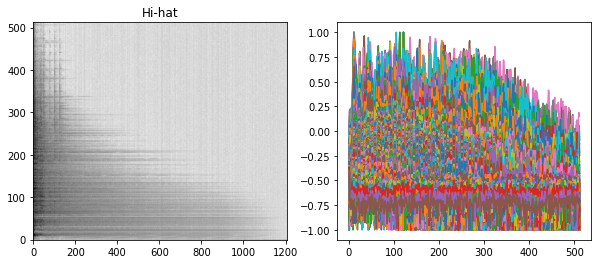

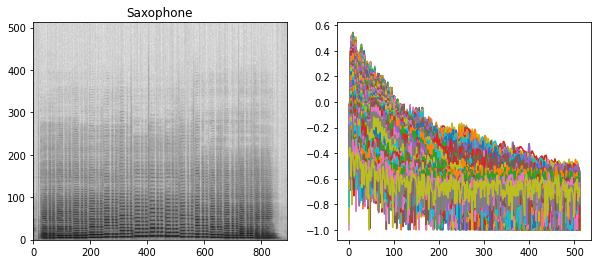

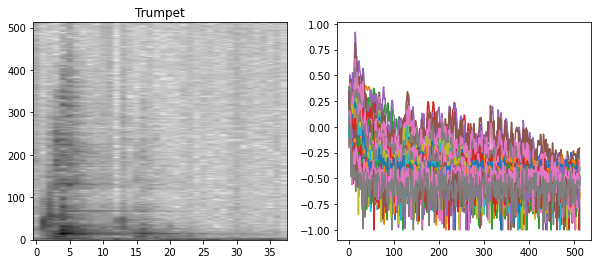

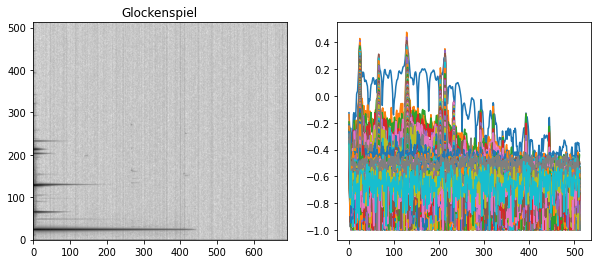

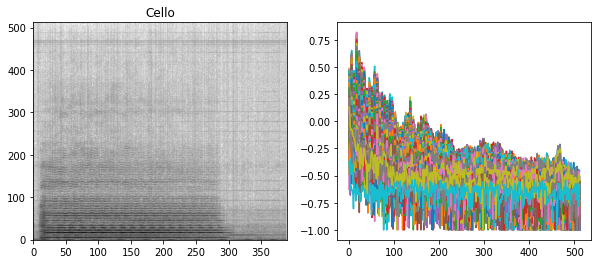

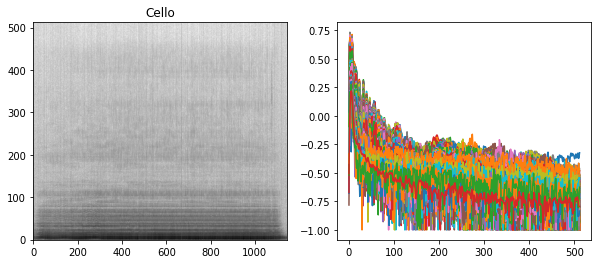

In [11]:
# # display 6 random spectrograms
# for i in range(6):

#     stft = extract_audio_feature(train_metadata.iloc[i]['data'], sr=train_metadata.iloc[i]['sr'], feature_type='stft')

#     # display the spectrogram and data side by side
#     plt.figure(figsize=(10, 4))
#     plt.subplot(1, 2, 1)
#     plt.imshow(stft, aspect='auto', origin='lower', cmap='gray_r')
#     plt.title(train_metadata.iloc[i]['label'])
#     plt.subplot(1, 2, 2)
#     plt.plot(stft)
#     plt.show()

# display 6 random spectrograms
for i in range(6):

    stft = extract_audio_feature(metadata.iloc[i]['data'], sr=metadata.iloc[i]['sr'], feature_type='stft')

    # display the spectrogram and data side by side
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(stft, aspect='auto', origin='lower', cmap='gray_r')
    plt.title(metadata.iloc[i]['label'])
    plt.subplot(1, 2, 2)
    plt.plot(stft)
    plt.show()


### Data Visualization 2/3
Display 6 audio **MFCCs** of the train_metadata,
Mel-frequency cepstral coefficients

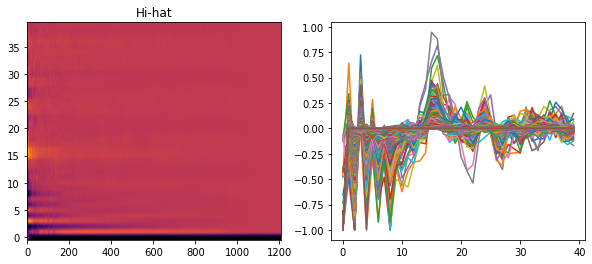

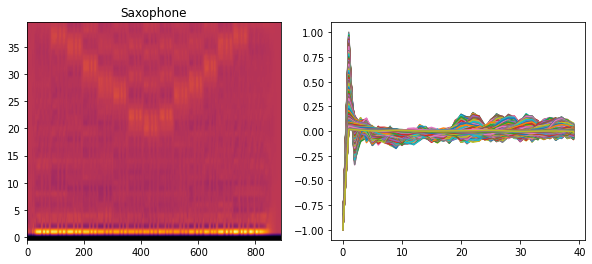

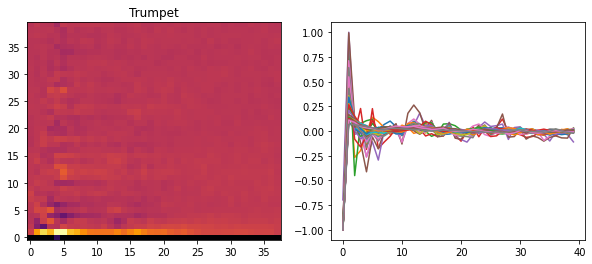

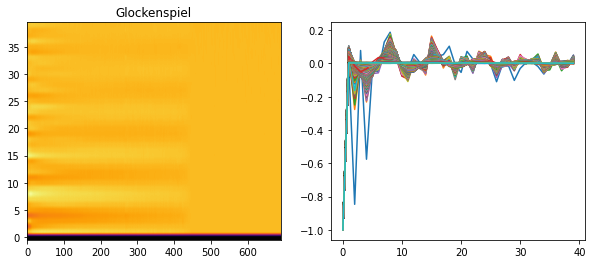

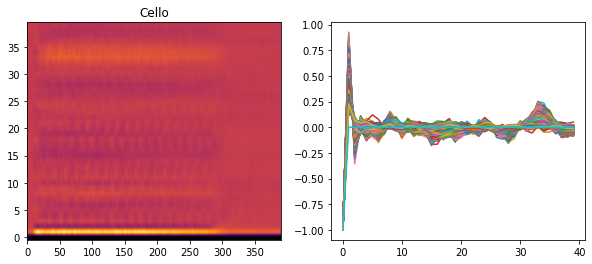

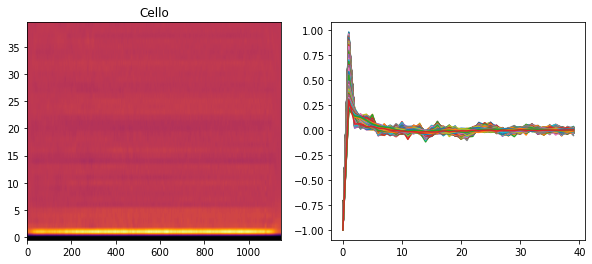

In [12]:
# # https://arxiv.org/pdf/1908.05863.pdf

# # display 6 random MFCCS
# for i in range(6):

#     mfcc = extract_audio_feature(train_metadata.iloc[i]['data'], sr=train_metadata.iloc[i]['sr'], feature_type='mfcc')

#     # display the spectrogram and data side by side
#     plt.figure(figsize=(10, 4))
#     plt.subplot(1, 2, 1)
#     plt.imshow(mfcc, aspect='auto', origin='lower', cmap="inferno")
#     plt.title(train_metadata.iloc[i]['label'])
#     plt.subplot(1, 2, 2)
#     plt.plot(mfcc)
#     plt.show()

# https://arxiv.org/pdf/1908.05863.pdf

# display 6 random MFCCS
for i in range(6):

    mfcc = extract_audio_feature(metadata.iloc[i]['data'], sr=metadata.iloc[i]['sr'], feature_type='mfcc')

    # display the spectrogram and data side by side
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(mfcc, aspect='auto', origin='lower', cmap="inferno")
    plt.title(metadata.iloc[i]['label'])
    plt.subplot(1, 2, 2)
    plt.plot(mfcc)
    plt.show()

### Data Visualization 3/3
Display 6 audio **MEL-Spectrogram** of the train_metadata

(128, 242)
(128, 242)
(128, 242)
(128, 242)
(128, 242)
(128, 178)
(128, 178)
(128, 178)
(128, 178)
(128, 178)
(128, 8)
(128, 8)
(128, 8)
(128, 8)
(128, 8)
(128, 138)
(128, 138)
(128, 138)
(128, 138)
(128, 138)
(128, 78)
(128, 78)
(128, 78)
(128, 78)
(128, 78)
(128, 229)
(128, 229)
(128, 229)
(128, 229)
(128, 229)
242
(30, 128, 242)


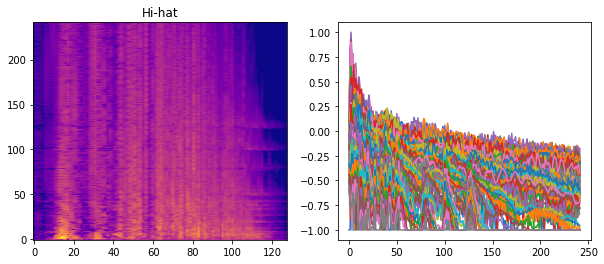

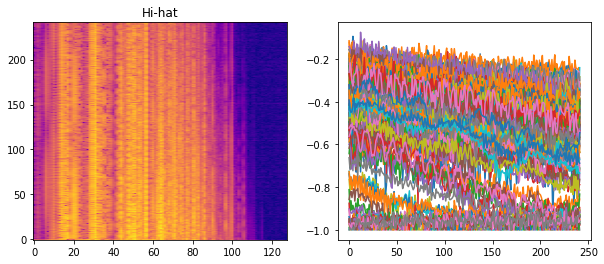

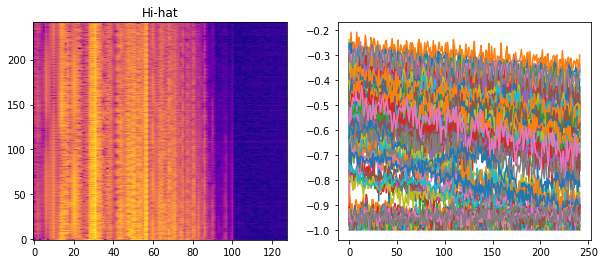

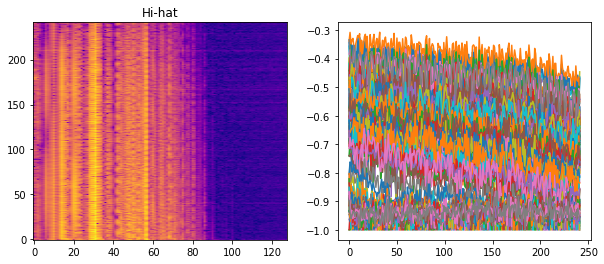

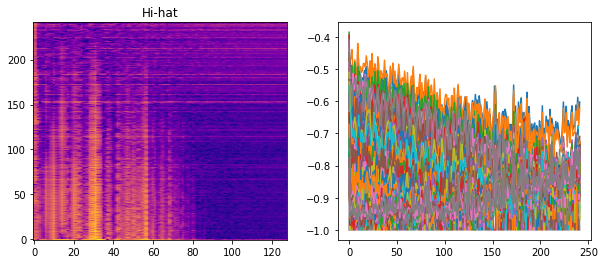

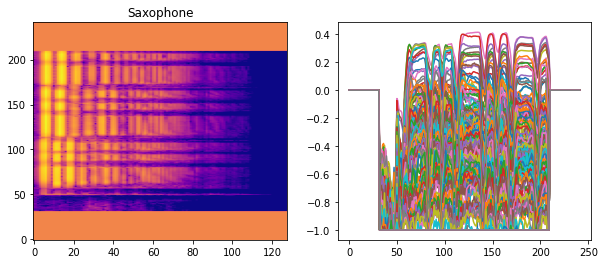

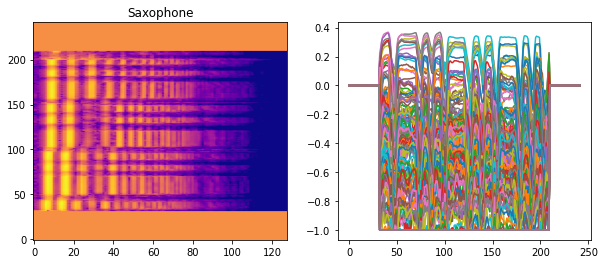

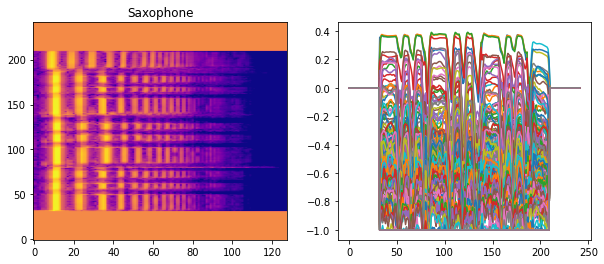

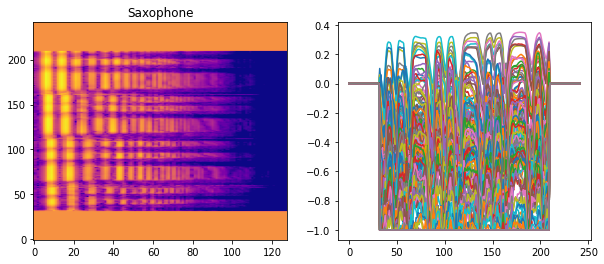

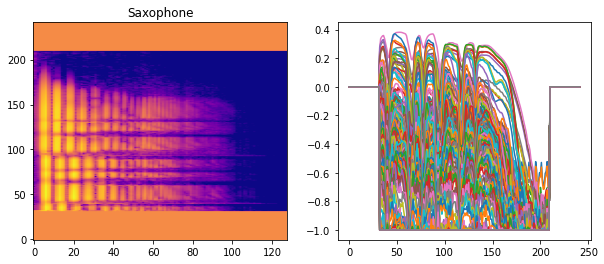

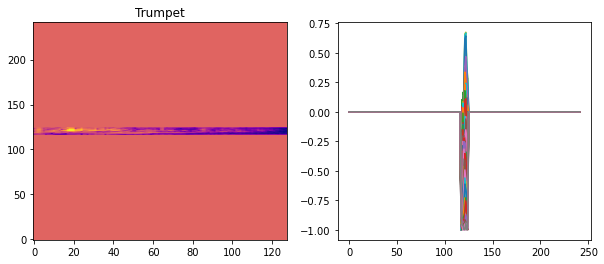

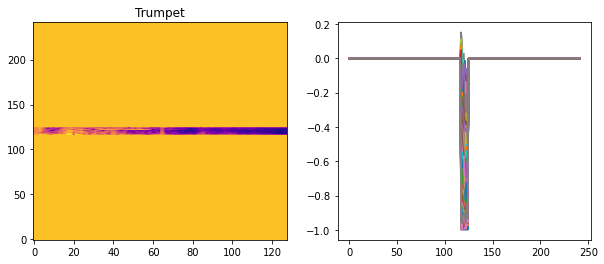

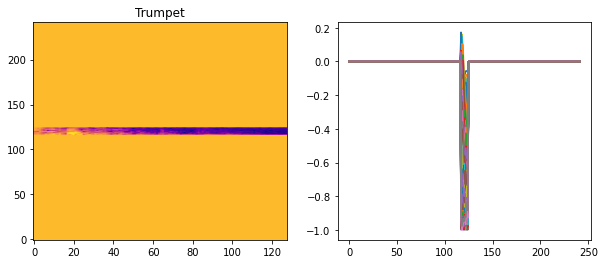

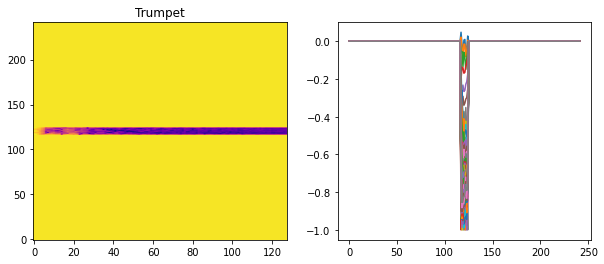

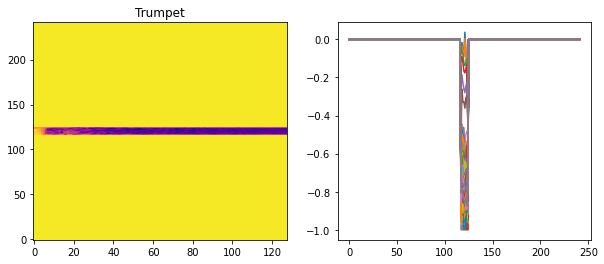

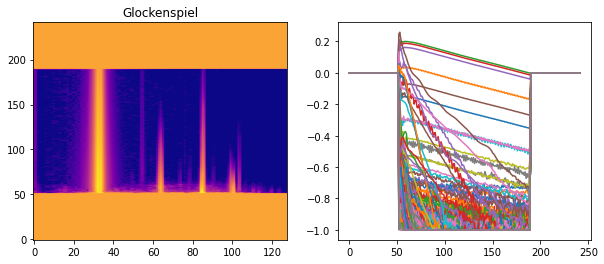

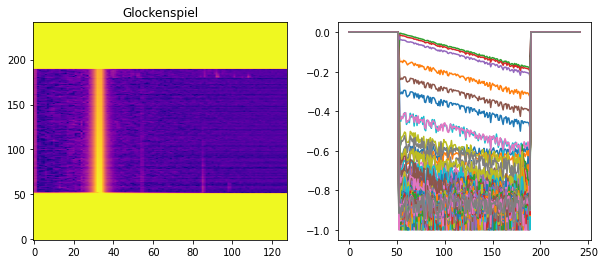

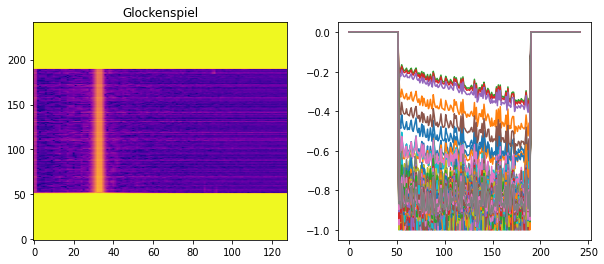

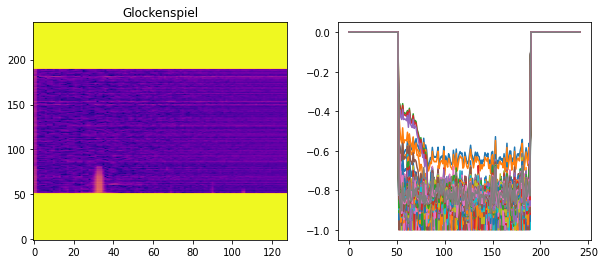

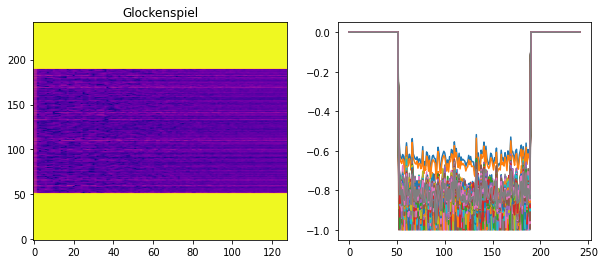

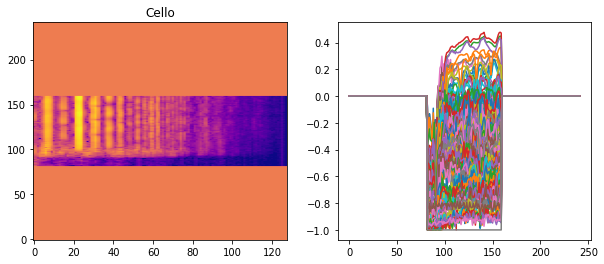

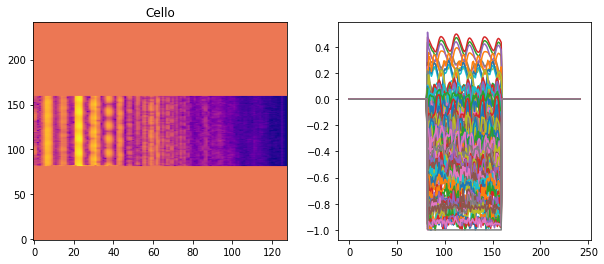

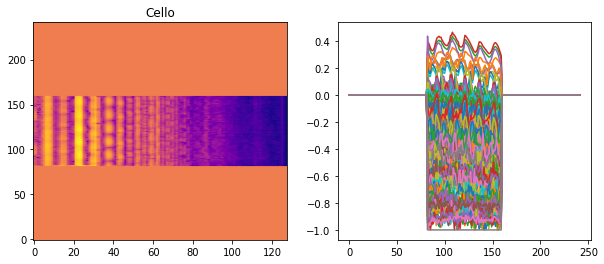

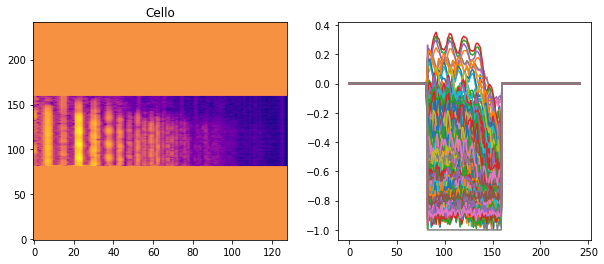

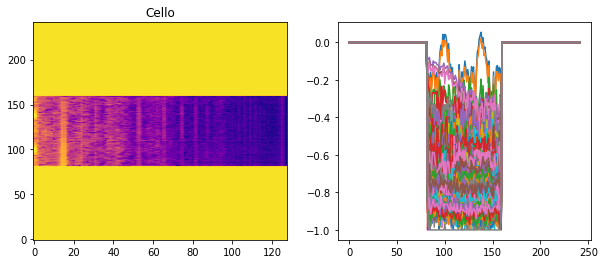

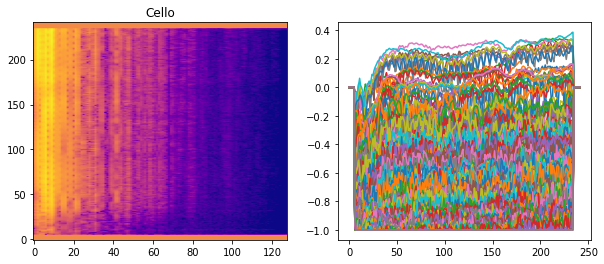

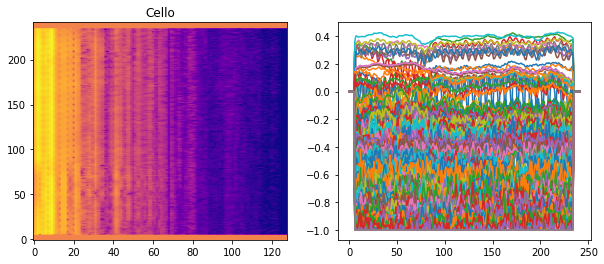

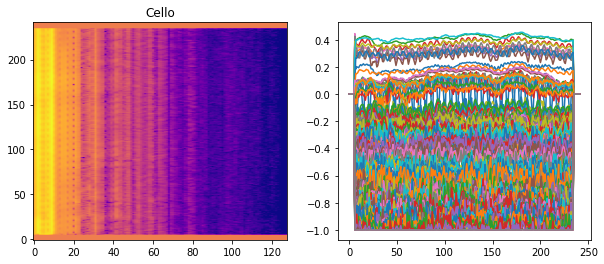

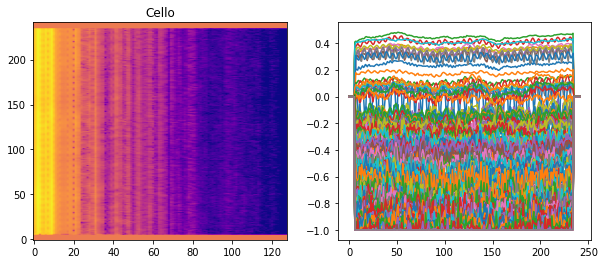

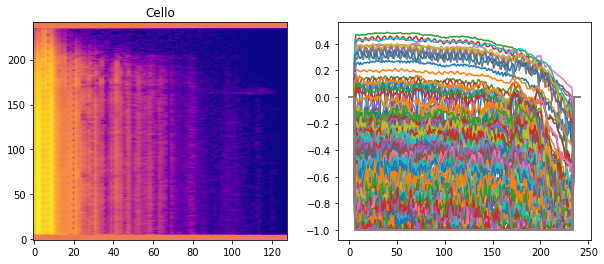

In [13]:

# # create MEL-scaled filter banks spectrograms
# features = []
# labels = []
# frames_max = 0
# # display 6 random mel spectrograms
# for i in range(6):

#     # # generate a mel scaled spectrogram
#     # mel_spectrogram = librosa.feature.melspectrogram(train_metadata.iloc[i]['data'], sr=train_metadata.iloc[i]['sr'], n_fft=1024) # n_mels=n_mels

#     # # convert the sound intensity to log scale
#     # mel_db = librosa.power_to_db(np.abs(mel_spectrogram)) #librosa.amplitude_to_db(np.abs(mel_spectrogram))

#     # # normalize the data to 0-1
#     # normalized_mel = librosa.util.normalize(mel_db)

#     num_segments = 5

#     SAMPLE_RATE = train_metadata.iloc[i]['sr']
#     TRACK_DURATION = train_metadata.iloc[i]['duration'] #7 # measured in seconds
#     SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

#     #num_mfcc=n_mfcc#13
#     n_fft=1024#2048
#     hop_length=512#64#128#256#512

#     samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
#     #num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

#     # process all segments of audio file
#     for d in range(num_segments):

#         # calculate start and finish sample for current segment
#         start = samples_per_segment * d
#         finish = start + samples_per_segment

#         try:

#             # generate a mel scaled spectrogram
#             # mel_spectrogram = librosa.feature.melspectrogram(train_metadata.iloc[i]['data'][start:finish], sr=train_metadata.iloc[i]['sr'], n_fft=n_fft, hop_length=hop_length)
#             # mel_spectrogram = librosa.amplitude_to_db(np.abs(mel_spectrogram))#librosa.power_to_db(np.abs(mel_spectrogram)) #librosa.amplitude_to_db(np.abs(mel_spectrogram))
#             # mel_spectrogram = librosa.util.normalize(mel_spectrogram)
#             mel_spectrogram = extract_audio_feature(train_metadata.iloc[i]['data'][start:finish], sr=train_metadata.iloc[i]['sr'], feature_type='mel')
#             #mel_spectrogram = mel_spectrogram.T # x:time y:frequency

#             # Save current frame count
#             num_frames = mel_spectrogram.shape[1]
            
#             # Add row (feature / label)
#             features.append(mel_spectrogram)
#             labels.append(train_metadata.iloc[i]["label"])

#             # Update frames maximum
#             if (num_frames > frames_max):
#                 frames_max = num_frames

#             # # plot the spectrogram and data side by side
#             # plt.figure(figsize=(10, 4))
#             # plt.subplot(1, 2, 1)
#             # plt.imshow(mel_spectrogram, aspect='auto', origin='lower', cmap='plasma')
#             # plt.title(train_metadata.iloc[i]['label'])
#             # plt.subplot(1, 2, 2)
#             # plt.plot(mel_spectrogram)
#             # plt.show()

#             print(mel_spectrogram.shape)

#         except Exception as e:
#             pass
#             #print(f"Error processing segment {row['fname']} {e}, probably not enough data to segment it")

# print(frames_max)
# padding = np.array(helper.add_padding(features, frames_max))
# print(padding.shape)

# new_padding = []
# # for every feature in padded_features tranpose and replace padded features
# for i in range(len(padding)):
#     new_padding.append(padding[i].T)

# padding = np.array(new_padding)

# for x, padded_frame_data in enumerate(padding):

#     #padded_frame_data = padded_frame_data.T

#     # plot the spectrogram and data side by side
#     plt.figure(figsize=(10, 4))
#     plt.subplot(1, 2, 1)
#     plt.imshow(padded_frame_data, aspect='auto', origin='lower', cmap='plasma')
#     plt.title(labels[x])
#     plt.subplot(1, 2, 2)
#     plt.plot(padded_frame_data)
#     plt.show()

#     # # plot the spectrogram and data side by side
#     # plt.figure(figsize=(10, 4))
#     # plt.subplot(1, 2, 1)
#     # plt.imshow(normalized_mel, aspect='auto', origin='lower', cmap='plasma')
#     # plt.title(train_metadata.iloc[i]['label'])
#     # plt.subplot(1, 2, 2)
#     # plt.plot(normalized_mel)
#     # plt.show()

# create MEL-scaled filter banks spectrograms
features = []
labels = []
frames_max = 0
# display 6 random mel spectrograms
for i in range(6):

    # # generate a mel scaled spectrogram
    # mel_spectrogram = librosa.feature.melspectrogram(train_metadata.iloc[i]['data'], sr=train_metadata.iloc[i]['sr'], n_fft=1024) # n_mels=n_mels

    # # convert the sound intensity to log scale
    # mel_db = librosa.power_to_db(np.abs(mel_spectrogram)) #librosa.amplitude_to_db(np.abs(mel_spectrogram))

    # # normalize the data to 0-1
    # normalized_mel = librosa.util.normalize(mel_db)

    num_segments = 5

    SAMPLE_RATE = metadata.iloc[i]['sr']
    TRACK_DURATION = metadata.iloc[i]['duration'] #7 # measured in seconds
    SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

    #num_mfcc=n_mfcc#13
    n_fft=1024#2048
    hop_length=512#64#128#256#512

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    #num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # process all segments of audio file
    for d in range(num_segments):

        # calculate start and finish sample for current segment
        start = samples_per_segment * d
        finish = start + samples_per_segment

        try:

            # generate a mel scaled spectrogram
            # mel_spectrogram = librosa.feature.melspectrogram(train_metadata.iloc[i]['data'][start:finish], sr=train_metadata.iloc[i]['sr'], n_fft=n_fft, hop_length=hop_length)
            # mel_spectrogram = librosa.amplitude_to_db(np.abs(mel_spectrogram))#librosa.power_to_db(np.abs(mel_spectrogram)) #librosa.amplitude_to_db(np.abs(mel_spectrogram))
            # mel_spectrogram = librosa.util.normalize(mel_spectrogram)
            mel_spectrogram = extract_audio_feature(metadata.iloc[i]['data'][start:finish], sr=metadata.iloc[i]['sr'], feature_type='mel')
            #mel_spectrogram = mel_spectrogram.T # x:time y:frequency

            # Save current frame count
            num_frames = mel_spectrogram.shape[1]
            
            # Add row (feature / label)
            features.append(mel_spectrogram)
            labels.append(metadata.iloc[i]["label"])

            # Update frames maximum
            if (num_frames > frames_max):
                frames_max = num_frames

            # # plot the spectrogram and data side by side
            # plt.figure(figsize=(10, 4))
            # plt.subplot(1, 2, 1)
            # plt.imshow(mel_spectrogram, aspect='auto', origin='lower', cmap='plasma')
            # plt.title(train_metadata.iloc[i]['label'])
            # plt.subplot(1, 2, 2)
            # plt.plot(mel_spectrogram)
            # plt.show()

            print(mel_spectrogram.shape)

        except Exception as e:
            pass
            #print(f"Error processing segment {row['fname']} {e}, probably not enough data to segment it")

print(frames_max)
padding = np.array(helper.add_padding(features, frames_max))
print(padding.shape)

new_padding = []
# for every feature in padded_features tranpose and replace padded features
for i in range(len(padding)):
    new_padding.append(padding[i].T)

padding = np.array(new_padding)

for x, padded_frame_data in enumerate(padding):

    #padded_frame_data = padded_frame_data.T

    # plot the spectrogram and data side by side
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(padded_frame_data, aspect='auto', origin='lower', cmap='plasma')
    plt.title(labels[x])
    plt.subplot(1, 2, 2)
    plt.plot(padded_frame_data)
    plt.show()

    # # plot the spectrogram and data side by side
    # plt.figure(figsize=(10, 4))
    # plt.subplot(1, 2, 1)
    # plt.imshow(normalized_mel, aspect='auto', origin='lower', cmap='plasma')
    # plt.title(train_metadata.iloc[i]['label'])
    # plt.subplot(1, 2, 2)
    # plt.plot(normalized_mel)
    # plt.show()


### Begin Feature Extraction For MFCC for train and test datasets
We will cache the feature extraction into npy files of the train and test datasets for training

In [14]:
def extract_mfcc_features(metadata_pd, n_mfcc=40, base_name=None, max_frames=0):

    if base_name is None:
        print("base_name is None")
        return

    base_name = 'mfcc-' + base_name

    print(f"Starting Extraction of MFCC features for base name: {base_name} total, {len(metadata_pd)} files")

    # Iterate through all audio files and extract MFCC
    features = []
    labels = []
    frames_max = max_frames
    counter = 0
    total_samples = len(metadata_pd)
    #mfcc_max_padding = 0

    for index, row in metadata_pd.iterrows():
        class_label = row["label"]

        num_segments = 5

        SAMPLE_RATE = row['sr']
        TRACK_DURATION = row['duration'] #7 # measured in seconds
        SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

        num_mfcc=n_mfcc#13
        n_fft=1024#2048
        hop_length=512#64#128#256#512

        samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
        #num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

        # Extract MFCC data
        #mfcc = librosa.feature.mfcc(row['data'], sr=row['sr'], n_mfcc=n_mfcc)
        
        # normalize the mfcc between -1 and 1
        #normalized_mfcc = librosa.util.normalize(mfcc)

        # process all segments of audio file
        for d in range(num_segments):

            # calculate start and finish sample for current segment
            start = samples_per_segment * d
            finish = start + samples_per_segment

            try:
                # extract mfcc

                mfcc = extract_audio_feature(row['data'][start:finish], sr=row['sr'], feature_type='mfcc')

                # mel_spectrogram = librosa.feature.melspectrogram(row['data'][start:finish], sr=row['sr'], n_fft=n_fft, hop_length=hop_length)
                # mel_spectrogram = librosa.power_to_db(np.abs(mel_spectrogram))#librosa.power_to_db(np.abs(mel_spectrogram)) #librosa.amplitude_to_db(np.abs(mel_spectrogram))
                # #mel_spectrogram = librosa.util.normalize(mel_spectrogram)
                # mfcc = librosa.feature.mfcc(S=mel_spectrogram, sr=row['sr'], n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                # mfcc = librosa.util.normalize(mfcc) # normalize the data
                # mfcc = mfcc.T # transpose the data to x:time y:frequency
  
                # # Should we require padding
                # shape = mfcc.shape[1]
                # if (mfcc_max_padding > 0 & shape < mfcc_max_padding):
                #     xDiff = mfcc_max_padding - shape
                #     xLeft = xDiff//2
                #     xRight = xDiff-xLeft
                #     mfcc = np.pad(mfcc, pad_width=((0,0), (xLeft, xRight)), mode='constant')

                # Save current frame count
                num_frames = mfcc.shape[1]
                
                # Add row (feature / label)
                features.append(mfcc)
                labels.append(class_label)

                # Update frames maximum
                if (num_frames > frames_max):
                    frames_max = num_frames

                # # display the spectrogram and data side by side
                # plt.figure(figsize=(10, 4))
                # plt.subplot(1, 2, 1)
                # plt.imshow(mfcc, aspect='auto', origin='lower', cmap="inferno")
                # plt.title(train_metadata.iloc[i]['label'])
                # plt.subplot(1, 2, 2)
                # plt.plot(mfcc)
                # plt.show()
            except Exception as e:
                print(f"Error processing segment {row['fname']} {e}, probably not enough data to segment it")

        

    

        # Notify update every N files
        if (counter == 500):
            print("Status: {}/{}".format(index+1, total_samples))
            counter = 0

        counter += 1
        
    print("Finished: {}/{} frames_max {}".format(index, total_samples, frames_max))
    # Add padding to features with less than frames than frames_max
    padded_features = np.array(helper.add_padding(features, frames_max))

    # new_padding = []
    # # for every feature in padded_features tranpose and replace padded features
    # for i in range(len(padded_features)):
    #     new_padding.append(padded_features[i].T)

    # padded_features = np.array(new_padding)

    # Verify shapes
    print("Raw features length: {}".format(len(features)))
    print("Padded features length: {}".format(len(padded_features)))
    print("Feature labels length: {}".format(len(labels)))
    #print(f"Shape of padded features: {padded_features.shape}, Shape of labels: {len(labels)}")

    # Convert features (X) and labels (y) to Numpy arrays
    X = np.array(padded_features)#padded_features # np.array(padded_features)
    y = np.array(labels)

    data_npy_folder = os.path.join(dataset_root_dir, 'data')

    # Optionally save the features to disk
    np.save( os.path.join(data_npy_folder, f"X-{base_name}" ), X)
    np.save( os.path.join(data_npy_folder, f"y-{base_name}" ), y)

    # free up memory
    del X
    del y
    del features
    del labels

    print(f"Finished Extraction of MFCC features for base name: {base_name} total, {len(metadata_pd)} files")
    return frames_max
    

In [15]:
# max_frames = extract_mfcc_features(metadata, n_mfcc=40, base_name='merged')
# print(f"\n\nmax frames: {max_frames}\n\n")



#max_frames = extract_mfcc_features(train_metadata, n_mfcc=40, base_name='train') # 517 The reason I want to pass through max frames to be the same is because I want to use the same max frames for all the features
#extract_mfcc_features(test_metadata, n_mfcc=40, base_name='test', max_frames=517)

### Begin Feature Extraction For MEL for train and test datasets
We will cache the feature extraction into npy files of the train and test datasets for training

In [9]:
def extract_mel_spectrogram_features(metadata_pd, n_fft=1024, base_name=None, max_frames=0):

    if base_name is None:
        print("base_name is None")
        return

    base_name = 'mel-' + base_name

    print(f"Starting Extraction of MEL-Spec features for base name: {base_name} total, {len(metadata_pd)} files")

    # Iterate through all audio files and extract mel spectrograms
    features = []
    labels = []
    frames_max = max_frames
    counter = 0
    total_samples = len(metadata_pd)
    #mel_max_padding = 0

    for index, row in metadata_pd.iterrows():
        num_segments = 5

        target_file = ""
        # detect if row["usage"] is NaN
        #print(str(row["usage"]).lower())
        if str(row["usage"]).lower() == "nan":
            # if nan its a test train
            target_file = os.path.join( train_dir, row['fname'] )
        else:
            target_file = os.path.join( test_dir, row['fname'] )

        # load the audio file
        y, sr = librosa.load( target_file )

        # normalize the audio with librosa
        normalized_y = librosa.util.normalize(y)

        SAMPLE_RATE = sr#row['sr']
        TRACK_DURATION = librosa.get_duration(y=y, sr=sr)#row['duration'] #7 # measured in seconds
        SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

        #num_mfcc=n_mfcc#13
        n_fft=1024#2048
        hop_length=512#64#128#256#512

        samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
        #num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

        # generate a mel scaled spectrogram
        #mel_spectrogram = librosa.feature.melspectrogram(row['data'], sr=row['sr'], n_fft=n_fft)#, n_mels=n_mels)

        # convert the sound intensity to log scale
        #mel_db = librosa.power_to_db(np.abs(mel_spectrogram)) #librosa.amplitude_to_db(np.abs(mel_spectrogram))

        # normalize the data to 0-1
        #normalized_mel = librosa.util.normalize(mel_db)

        # # Should we require padding
        # shape = normalized_mel.shape[1]
        # if (mel_max_padding > 0 & shape < mel_max_padding):
        #     xDiff = mel_max_padding - shape
        #     xLeft = xDiff//2
        #     xRight = xDiff-xLeft
        #     normalized_mel = np.pad(normalized_mel, pad_width=((0,0), (xLeft, xRight)), mode='constant')
        #     print("[WARNING] PADDING MEL-SPEC")


        

        # process all segments of audio file
        for d in range(num_segments):

            # calculate start and finish sample for current segment
            start = samples_per_segment * d
            finish = start + samples_per_segment

            try:


                mel_spectrogram = extract_audio_feature(normalized_y[start:finish], sr=sr, feature_type='mel')
                #mel_spectrogram = extract_audio_feature(row['data'][start:finish], sr=row['sr'], feature_type='mel')

                # Save current frame count
                num_frames = mel_spectrogram.shape[1]
                
                # Add row (feature / label)
                features.append(mel_spectrogram)
                labels.append(row["label"])

                # Update frames maximum
                if (num_frames > frames_max):
                    frames_max = num_frames

            except Exception as e:
                print(f"Error processing segment {row['fname']} {e}, probably not enough data to segment it")

        # Notify update every N files
        if (counter == 500):
            print("Status: {}/{}".format(index+1, total_samples))
            counter = 0

        counter += 1
        
    print("Finished: {}/{} frames_max {}".format(index, total_samples, frames_max))
    # Add padding to features with less than frames than frames_max
    padded_features = helper.add_padding(features, frames_max)

    # new_padding = []
    # # for every feature in padded_features tranpose and replace padded features
    # for i in range(len(padded_features)):
    #     new_padding.append(padded_features[i].T)

    # padded_features = np.array(new_padding)

    # Verify shapes
    print("Raw features length: {}".format(len(features)))
    print("Padded features length: {}".format(len(padded_features)))
    print("Feature labels length: {}".format(len(labels)))
    #print(f"Shape of padded features: {padded_features.shape}, Shape of labels: {len(labels)}")

    # Convert features (X) and labels (y) to Numpy arrays
    X = np.array(padded_features)#padded_features#np.array(padded_features)
    y = np.array(labels)

    data_npy_folder = os.path.join(dataset_root_dir, 'data')

    # Optionally save the features to disk
    np.save( os.path.join(data_npy_folder, f"X-{base_name}" ), X)
    np.save( os.path.join(data_npy_folder, f"y-{base_name}" ), y)

    # free up memory
    del X
    del y
    del features
    del labels
    print(f"Finished Extraction of MEL-Spec features for base name: {base_name} total, {len(metadata_pd)} files")
    return frames_max

In [11]:
# max_frames = extract_mel_spectrogram_features(train_metadata, base_name='train')
# extract_mel_spectrogram_features(test_metadata, base_name='test', max_frames=max_frames)

max_frames = extract_mel_spectrogram_features(metadata, base_name='merged')
print(f"\n\nmax frames: {max_frames}\n\n")

Starting Extraction of MEL-Spec features for base name: mel-merged total, 11073 files
Status: 501/11073
Status: 1001/11073
Status: 1501/11073
Status: 2001/11073
Status: 2501/11073
Status: 3001/11073
Status: 3501/11073
Status: 4001/11073
Status: 4501/11073
Status: 5001/11073
Status: 5501/11073
Status: 6001/11073
Status: 6501/11073
Status: 7001/11073
Status: 7501/11073
Status: 8001/11073
Status: 8501/11073
Status: 9001/11073
Status: 28/11073
Status: 528/11073
Status: 1028/11073
Status: 1528/11073
Finished: 1599/11073 frames_max 259
Raw features length: 55365
Padded features length: 55365
Feature labels length: 55365
Finished Extraction of MEL-Spec features for base name: mel-merged total, 11073 files


max frames: 259


